## PARTE 1: CREACIÓN Y ENTRENAMIENTO DEL MODELO CONVOLUCIONAL 2D BASE


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import os
import mlflow
from getpass import getpass

# ############### Inicializamos conectividad con el repositorio "Experimentos" en DagsHub ###########
REPO_NAME = "Experimentos"
REPO_OWNER = "carlosfcfm"  # Escribir nombre de repositorio
USER_NAME = "carlosfcfm"  # Escribir su usuario
os.environ['MLFLOW_TRACKING_USERNAME'] = USER_NAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token or password: ')
mlflow.set_tracking_uri(f'https://dagshub.com/{REPO_OWNER}/{REPO_NAME}.mlflow')

# Rutas
base_dir = r'C:\Users\LamdaZero\Desktop\Proyecto final REDES'
img_dir = os.path.join(base_dir, 'img_align_celeba')
attr_csv = os.path.join(base_dir, 'list_attr_celeba.csv')
partition_csv = os.path.join(base_dir, 'list_eval_partition.csv')

# Cargamos los CSVs
attributes = pd.read_csv(attr_csv)
partitions = pd.read_csv(partition_csv)
data = attributes.merge(partitions, on='image_id')

# Mapeamos -1 a 0 para etiquetas binarias
attr_columns = data.columns[1:41]  # Seleccionamos las 40 columnas de atributos
data[attr_columns] = (data[attr_columns] + 1) // 2  # De -1/1 a 0/1

# Filtramos el train (0) y val (1)
train_data = data[data['partition'] == 0]
val_data = data[data['partition'] == 1]
# En este caso el dataset ya viene estratificado, por eso mismo no necesito hacerlo por mi cuenta
# Tiene aproximadamente el 80% en train, 10% validación y 10% train
# Generadores de datos con augmentación para train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    channel_shift_range=0.1,
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Función para generar flow_from_dataframe
def create_generator(datagen, df, batch_size=8, target_size=(96, 96)):
    return datagen.flow_from_dataframe(
        df,
        directory=img_dir,
        x_col='image_id',
        y_col=attr_columns.tolist(),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw' 
    )

train_generator = create_generator(train_datagen, train_data)
val_generator = create_generator(val_datagen, val_data)

# Modelo convolucional 2D
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(96,96,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(512, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(512, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(40, activation='sigmoid')  
])

# #### Setup y entrenamiento del modelo con logging de MLflow y callbacks ################################
filepath = os.path.join(base_dir, 'celeba_attribute_model_improved.keras')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.2, patience=4, min_lr=1e-7, verbose=1)

mlflow.set_experiment("experimentos_celebA")  
mlflow.start_run(nested=True)
mlflow.tensorflow.autolog(log_models=False)

model.compile(
    optimizer=AdamW(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_data) // 32,
    validation_data=val_generator,
    validation_steps=len(val_data) // 32,
    epochs=50,  
    verbose=1,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

model.save(filepath)
mlflow.log_artifact(filepath, artifact_path="models")
mlflow.end_run()
model.save(os.path.join(base_dir, 'celeba_attribute_model.h5'))

Found 162770 validated image filenames.
Found 19867 validated image filenames.


c:\Users\LamdaZero\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025/11/29 03:26:55 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.
2025/11/29 03:26:55 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.
c:\Users\LamdaZero\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`,

Epoch 1/50
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - binary_accuracy: 0.8036 - loss: 0.4474
Epoch 1: val_loss improved from None to 0.38841, saving model to C:\Users\LamdaZero\Desktop\Proyecto final REDES\celeba_attribute_model_improved.keras


5086/5086 ━━━━━━━━━━━━━━━━━━━━ 992s 194ms/step - binary_accuracy: 0.8127 - loss: 0.4263 - val_binary_accuracy: 0.8312 - val_loss: 0.3884 - learning_rate: 0.0010
Epoch 2/50
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - binary_accuracy: 0.8294 - loss: 0.3897
Epoch 2: val_loss improved from 0.38841 to 0.35053, saving model to C:\Users\LamdaZero\Desktop\Proyecto final REDES\celeba_attribute_model_improved.keras


5086/5086 ━━━━━━━━━━━━━━━━━━━━ 991s 195ms/step - binary_accuracy: 0.8332 - loss: 0.3801 - val_binary_accuracy: 0.8456 - val_loss: 0.3505 - learning_rate: 0.0010
Epoch 3/50
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - binary_accuracy: 0.8399 - loss: 0.3621
Epoch 3: val_loss improved from 0.35053 to 0.34458, saving model to C:\Users\LamdaZero\Desktop\Proyecto final REDES\celeba_attribute_model_improved.keras


5086/5086 ━━━━━━━━━━━━━━━━━━━━ 996s 196ms/step - binary_accuracy: 0.8424 - loss: 0.3571 - val_binary_accuracy: 0.8610 - val_loss: 0.3446 - learning_rate: 0.0010
Epoch 4/50
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - binary_accuracy: 0.8488 - loss: 0.3450
Epoch 4: val_loss did not improve from 0.34458
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 980s 193ms/step - binary_accuracy: 0.8512 - loss: 0.3411 - val_binary_accuracy: 0.8703 - val_loss: 0.4817 - learning_rate: 0.0010
Epoch 5/50
   3/5086 ━━━━━━━━━━━━━━━━━━━━ 15:20 181ms/step - binary_accuracy: 0.8582 - loss: 0.3274

c:\Users\LamdaZero\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 5: val_loss did not improve from 0.34458
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - binary_accuracy: 0.8635 - loss: 0.3182 - val_binary_accuracy: 0.8706 - val_loss: 0.4655 - learning_rate: 0.0010
Epoch 6/50
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - binary_accuracy: 0.8558 - loss: 0.3301
Epoch 6: val_loss did not improve from 0.34458
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 975s 192ms/step - binary_accuracy: 0.8570 - loss: 0.3272 - val_binary_accuracy: 0.8741 - val_loss: 0.4987 - learning_rate: 0.0010
Epoch 7/50
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - binary_accuracy: 0.8605 - loss: 0.3202
Epoch 7: val_loss did not improve from 0.34458
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 986s 194ms/step - binary_accuracy: 0.8611 - loss: 0.3182 - val_binary_accuracy: 0.8736 - val_loss: 0.4069 - learning_rate: 0.0010
Epoch 8/50
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - binary_accuracy: 0.8645 - loss: 0.3104
Epoch 8: val_loss improved from 0.34458 to 0.29666, saving model to C:\Users\LamdaZero\

5086/5086 ━━━━━━━━━━━━━━━━━━━━ 1014s 199ms/step - binary_accuracy: 0.8648 - loss: 0.3097 - val_binary_accuracy: 0.8837 - val_loss: 0.2967 - learning_rate: 0.0010
Epoch 9/50
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - binary_accuracy: 0.8672 - loss: 0.3041
Epoch 9: val_loss improved from 0.29666 to 0.27346, saving model to C:\Users\LamdaZero\Desktop\Proyecto final REDES\celeba_attribute_model_improved.keras


5086/5086 ━━━━━━━━━━━━━━━━━━━━ 1020s 201ms/step - binary_accuracy: 0.8672 - loss: 0.3036 - val_binary_accuracy: 0.8820 - val_loss: 0.2735 - learning_rate: 0.0010
Epoch 10/50
   3/5086 ━━━━━━━━━━━━━━━━━━━━ 16:39 197ms/step - binary_accuracy: 0.8672 - loss: 0.3002
Epoch 10: val_loss improved from 0.27346 to 0.27234, saving model to C:\Users\LamdaZero\Desktop\Proyecto final REDES\celeba_attribute_model_improved.keras


5086/5086 ━━━━━━━━━━━━━━━━━━━━ 60s 12ms/step - binary_accuracy: 0.8687 - loss: 0.3055 - val_binary_accuracy: 0.8825 - val_loss: 0.2723 - learning_rate: 0.0010
Epoch 11/50
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - binary_accuracy: 0.8684 - loss: 0.3003
Epoch 11: val_loss did not improve from 0.27234
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 982s 193ms/step - binary_accuracy: 0.8686 - loss: 0.3000 - val_binary_accuracy: 0.8437 - val_loss: 2.7506 - learning_rate: 0.0010
Epoch 12/50
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - binary_accuracy: 0.8696 - loss: 0.2980
Epoch 12: val_loss did not improve from 0.27234

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 986s 194ms/step - binary_accuracy: 0.8697 - loss: 0.2972 - val_binary_accuracy: 0.8673 - val_loss: 0.3118 - learning_rate: 0.0010
Epoch 13/50
5086/5086 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - binary_accuracy: 0.8736 - loss: 0.2877
Epoch 13: val_loss did not improve from 0.27234
50

🏃 View run bald-roo-499 at: https://dagshub.com/carlosfcfm/Experimentos.mlflow/#/experiments/22/runs/b3f5f187a9384503a63d9ebbab1bf5a5
🧪 View experiment at: https://dagshub.com/carlosfcfm/Experimentos.mlflow/#/experiments/22


## PARTE 2: GENERADOR Y AUMENTO DE IMAGENES DEL DATASET (TRAIN) DE MI ROSTRO

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np

# Rutas
base_dir = r'C:\Users\LamdaZero\Desktop\Proyecto final REDES'
my_faces_dir = os.path.join(base_dir, 'my_faces')
augmented_dir = os.path.join(base_dir, 'augmented_my_faces')
os.makedirs(augmented_dir, exist_ok=True)

# DataGenerator para aumentar artificialmente las imagenes
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.6, 1.4]
)

# Para cada imagen en la carpeta my_faces que contiene 52 imagenes
for filename in os.listdir(my_faces_dir):
    if filename.endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(my_faces_dir, filename)
        img = load_img(img_path)  # carga imagen
        x = img_to_array(img)  # convertimos a array
        x = x.reshape((1,) + x.shape)  # Batch de 1

        # Generamos 100 augmentadas por original 
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_dir, save_prefix='aug_' + filename.split('.')[0], save_format='jpeg'):
            i += 1
            if i > 10:
                break

print("Augmentación completada. Imágenes guardadas en augmented_my_faces.")

Augmentación completada. Imágenes guardadas en augmented_my_faces.


## PARTE 3: HACEMOS TRANSFER-LEARNING CON OTRO CLASIFICADOR Y CONGELANDO LOS PESOS DEL MODELO BASE

In [ ]:
import pandas as pd
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

# Rutas
base_dir = r'C:\Users\LamdaZero\Desktop\Proyecto final REDES'
img_dir = os.path.join(base_dir, 'img_align_celeba')
augmented_dir = os.path.join(base_dir, 'augmented_my_faces')
attr_csv = os.path.join(base_dir, 'list_attr_celeba.csv')
partition_csv = os.path.join(base_dir, 'list_eval_partition.csv')
pretrained_model_path = os.path.join(base_dir, 'celeba_attribute_model.h5')  

# ------- 1. Contamos positivos (imagenes que si son de mi rostro) ----------------------
positive_files = [f for f in os.listdir(augmented_dir) if f.endswith(('.jpeg', '.jpg', '.png'))]
n_positives = len(positive_files)
n_negatives = n_positives * 2  # Hacemos balance 1:2, teniendo el doble de negativos (imagenes que no son de mi rostro) que de positivos


# ----------- 2. Preparamos negativos con características similares ----------------- #
# Cargamos atributos y particiones
attributes = pd.read_csv(attr_csv)
partitions = pd.read_csv(partition_csv)

# Filtramos solo el dataset de train (partition==0) y unimos atributos
train_part = partitions[partitions['partition'] == 0]
train_data = train_part.merge(attributes, on='image_id')

# Mapeamos -1 a 0 para consistencia
attr_columns = train_data.columns[2:]  # Atributos
train_data[attr_columns] = (train_data[attr_columns] + 1) // 2  

# Definimos filtros basados en los atributos de mi rostro
attr_filters = {
    'Male': 1,          
    'Young': 1,         
    'Eyeglasses': 1,    
    'Black_Hair': 1,    
    'No_Beard': 1       
}

# Filtramos negativos similares
similar_negatives = train_data.copy()
for attr, value in attr_filters.items():
    similar_negatives = similar_negatives[similar_negatives[attr] == value]

print(f"Número de negativos similares disponibles: {len(similar_negatives)}")

# Sampleamos similares y si no hay, ocupamos aleatorios extra
if len(similar_negatives) < n_negatives:
    print("No hay suficientes similares—usando todos + aleatorios extras")
    train_negatives = similar_negatives
    extras_needed = n_negatives - len(similar_negatives)
    if extras_needed > 0:
        extras = train_data[~train_data['image_id'].isin(similar_negatives['image_id'])].sample(extras_needed)
        train_negatives = pd.concat([train_negatives, extras])
else:
    train_negatives = similar_negatives.sample(n_negatives)

# ------------ 3. Creamos dataframes ----------------------------------------------
positive_df = pd.DataFrame({'filename': positive_files, 'label': 1.0})
positive_df['path'] = augmented_dir + '\\' + positive_df['filename']

negative_df = pd.DataFrame({'filename': train_negatives['image_id'], 'label': 0.0})
negative_df['path'] = img_dir + '\\' + negative_df['filename']

all_data = pd.concat([positive_df, negative_df[['filename', 'label', 'path']]], ignore_index=True)
train_df, val_df = train_test_split(all_data, test_size=0.2, stratify=all_data['label'], random_state=42)

print("Distribución train:", train_df['label'].value_counts().to_dict())
print("Distribución val:  ", val_df['label'].value_counts().to_dict())

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='path', y_col='label',
    target_size=(96, 96),  
    batch_size=32,
    class_mode='raw',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df, x_col='path', y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='raw'
)

# --------------- 5. Cargamos y modificamos el modelo -------------------------------------
model = load_model(pretrained_model_path)
model.build((None, 96, 96, 3))  

# Eliminamos las capas finales (son las capas del clasificador)
model.pop()  # Última dense (40)
model.pop()  # Dropout
model.pop()  # Dense intermedia

model.summary()

# Añadimos el nuevo clasificador
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

# Congelamos las capas base
for layer in model.layers[:-3]:
    layer.trainable = False

# Compilar
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']  
)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Usamos class weight para priorizar positivos 
class_weight = {0: 1.0, 1: 1.5}  # Le damos un poco de más peso a positivos

history = model.fit(
    train_generator,
    steps_per_epoch=max(1, len(train_df) // 32),
    validation_data=val_generator,
    validation_steps=max(1, len(val_df) // 32),
    epochs=30,
    callbacks=[reduce_lr, early_stop],
    class_weight=class_weight
)

model.save(os.path.join(base_dir, 'face_recognizer_frozen_similar.h5'))


Número de negativos similares disponibles: 572
No hay suficientes similares—usando todos + aleatorios extras
Distribución train: {0.0: 915, 1.0: 457}
Distribución val:   {0.0: 229, 1.0: 115}
Found 1372 validated image filenames.
Found 344 validated image filenames.


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 94, 94, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 94, 94, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 20, 20, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,916,674 (14.94 MB)

 Trainable params: 3,913,728 (14.93 MB)

 Non-trainable params: 2,944 (11.50 KB)

 Optimizer params: 2 (12.00 B)

2025/11/29 10:43:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a63ef2d7948d4accba0011b0a6072247', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/11/29 10:43:07 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.
2025/11/29 10:43:07 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.
c:\Users\LamdaZero\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - binary_accuracy: 0.6978 - loss: 0.9927

42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - binary_accuracy: 0.7634 - loss: 0.8848 - val_binary_accuracy: 0.8875 - val_loss: 0.3507 - learning_rate: 0.0010
Epoch 2/30
 1/42 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - binary_accuracy: 0.8438 - loss: 0.5050

c:\Users\LamdaZero\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - binary_accuracy: 0.8438 - loss: 0.5050 - val_binary_accuracy: 0.8844 - val_loss: 0.3547 - learning_rate: 0.0010
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - binary_accuracy: 0.7943 - loss: 0.5701

42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 821ms/step - binary_accuracy: 0.8127 - loss: 0.5560 - val_binary_accuracy: 0.9125 - val_loss: 0.2732 - learning_rate: 0.0010
Epoch 4/30
 1/42 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - binary_accuracy: 0.8750 - loss: 0.4045

42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 392ms/step - binary_accuracy: 0.8750 - loss: 0.4045 - val_binary_accuracy: 0.9125 - val_loss: 0.2667 - learning_rate: 0.0010
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - binary_accuracy: 0.8755 - loss: 0.4279

42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 825ms/step - binary_accuracy: 0.8694 - loss: 0.4243 - val_binary_accuracy: 0.9125 - val_loss: 0.2263 - learning_rate: 0.0010
Epoch 6/30
 1/42 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - binary_accuracy: 0.8750 - loss: 0.4010
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 383ms/step - binary_accuracy: 0.8750 - loss: 0.4010 - val_binary_accuracy: 0.9094 - val_loss: 0.2202 - learning_rate: 0.0010
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 536ms/step - binary_accuracy: 0.8821 - loss: 0.3684 - val_binary_accuracy: 0.9125 - val_loss: 0.2214 - learning_rate: 5.0000e-04
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - binary_accuracy: 0.8750 - loss: 0.2639 - val_binary_accuracy: 0.9094 - val_loss: 0.2225 - learning_rate: 5.0000e-04
Epoch 9/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - binary_accuracy: 0.9026 - loss: 0.5176

42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 844ms/step - binary_accuracy: 0.9000 - loss: 0.5343 - val_binary_accuracy: 0.9156 - val_loss: 0.2023 - learning_rate: 5.0000e-04
Epoch 10/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - binary_accuracy: 0.9688 - loss: 0.3055 - val_binary_accuracy: 0.9125 - val_loss: 0.2051 - learning_rate: 5.0000e-04
Epoch 11/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - binary_accuracy: 0.8882 - loss: 0.8152

42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 839ms/step - binary_accuracy: 0.8955 - loss: 0.5054 - val_binary_accuracy: 0.9156 - val_loss: 0.1978 - learning_rate: 5.0000e-04
Epoch 12/30
 1/42 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - binary_accuracy: 0.7812 - loss: 0.4514

42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 404ms/step - binary_accuracy: 0.7812 - loss: 0.4514 - val_binary_accuracy: 0.9250 - val_loss: 0.1874 - learning_rate: 5.0000e-04
Epoch 13/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - binary_accuracy: 0.8861 - loss: 1.4735

42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 835ms/step - binary_accuracy: 0.8963 - loss: 0.7442 - val_binary_accuracy: 0.9250 - val_loss: 0.1765 - learning_rate: 5.0000e-04
Epoch 14/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - binary_accuracy: 0.8125 - loss: 0.3820 - val_binary_accuracy: 0.9219 - val_loss: 0.1818 - learning_rate: 5.0000e-04
Epoch 15/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - binary_accuracy: 0.8935 - loss: 0.3308
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 539ms/step - binary_accuracy: 0.8985 - loss: 0.3126 - val_binary_accuracy: 0.9094 - val_loss: 0.1901 - learning_rate: 5.0000e-04
Epoch 16/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - binary_accuracy: 0.8438 - loss: 0.3214 - val_binary_accuracy: 0.9094 - val_loss: 0.1922 - learning_rate: 2.5000e-04
Epoch 17/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 540ms/step - binary_accuracy: 0.9037 - loss: 0.3621 - val_binary_accuracy: 0.9125 - val_loss: 0.1858 - learning_rate: 2.5000

## PARTE 4: FINE-TUNNING

In [ ]:
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam


base_dir = r'C:\Users\LamdaZero\Desktop\Proyecto final REDES'
frozen_model_path = os.path.join(base_dir, 'face_recognizer_frozen_similar.h5')

model = load_model(frozen_model_path)


for layer in model.layers[-6:]:  
    layer.trainable = True


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // 32,
    validation_data=val_generator,
    validation_steps=len(val_df) // 32,
    epochs=15,
    callbacks = [reduce_lr, early_stop]
)


model.save(os.path.join(base_dir, 'face_recognizer_finetuned.h5'))
print("Fine-tuning completado y modelo guardado.")

2025/11/29 10:50:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0b870bff6a9c45fba20f9b78c88a1ca8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/11/29 10:50:03 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.
2025/11/29 10:50:03 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.


Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8316 - loss: 0.3300

42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 841ms/step - accuracy: 0.8709 - loss: 0.2834 - val_accuracy: 0.9125 - val_loss: 0.2190 - learning_rate: 1.0000e-04
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9688 - loss: 0.2078 - val_accuracy: 0.8969 - val_loss: 0.2276 - learning_rate: 1.0000e-04
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 570ms/step - accuracy: 0.8925 - loss: 0.2521 - val_accuracy: 0.9000 - val_loss: 0.2266 - learning_rate: 1.0000e-04
Epoch 4/15
 1/42 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9375 - loss: 0.1858
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 401ms/step - accuracy: 0.9375 - loss: 0.1858 - val_accuracy: 0.9094 - val_loss: 0.2085 - learning_rate: 1.0000e-04
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8879 - loss: 0.2464

42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 826ms/step - accuracy: 0.8910 - loss: 0.2455 - val_accuracy: 0.9125 - val_loss: 0.1963 - learning_rate: 5.0000e-05
Epoch 6/15
 1/42 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.8750 - loss: 0.2481

42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 410ms/step - accuracy: 0.8750 - loss: 0.2481 - val_accuracy: 0.9094 - val_loss: 0.1906 - learning_rate: 5.0000e-05
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9165 - loss: 0.2456

42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 837ms/step - accuracy: 0.9082 - loss: 0.2389 - val_accuracy: 0.9156 - val_loss: 0.1830 - learning_rate: 5.0000e-05
Epoch 8/15
 1/42 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.8750 - loss: 0.3398

42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 401ms/step - accuracy: 0.8750 - loss: 0.3398 - val_accuracy: 0.9187 - val_loss: 0.1829 - learning_rate: 5.0000e-05
Epoch 9/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9007 - loss: 0.2457

42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 838ms/step - accuracy: 0.9000 - loss: 0.2383 - val_accuracy: 0.9187 - val_loss: 0.1771 - learning_rate: 5.0000e-05
Epoch 10/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9375 - loss: 0.1866 - val_accuracy: 0.9187 - val_loss: 0.1773 - learning_rate: 5.0000e-05
Epoch 11/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9104 - loss: 0.2258

42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 843ms/step - accuracy: 0.9075 - loss: 0.2284 - val_accuracy: 0.9250 - val_loss: 0.1672 - learning_rate: 5.0000e-05
Epoch 12/15
 1/42 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.8750 - loss: 0.2490

42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 390ms/step - accuracy: 0.8750 - loss: 0.2490 - val_accuracy: 0.9250 - val_loss: 0.1623 - learning_rate: 5.0000e-05
Epoch 13/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 550ms/step - accuracy: 0.9075 - loss: 0.2273 - val_accuracy: 0.9187 - val_loss: 0.1727 - learning_rate: 5.0000e-05
Epoch 14/15
 1/42 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.7500 - loss: 0.4385
Epoch 14: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.7500 - loss: 0.4385 - val_accuracy: 0.9156 - val_loss: 0.1742 - learning_rate: 5.0000e-05
Epoch 15/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 564ms/step - accuracy: 0.9104 - loss: 0.2374 - val_accuracy: 0.9250 - val_loss: 0.1684 - learning_rate: 2.5000e-05
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 12.
🏃 View run invincible-ray-90 at: https://dagshub.com/carlosfcfm/Experimentos.mlflow/#/experiments/22/runs/0b870bff6a9c45fba20f9b78c88a1ca8
🧪 Vie

Fine-tuning completado y modelo guardado.


## PARTE 5: CREAMOS UN DATASET DE TEST, DONDE TENGA IMAGENES DE MI ROSTRO (67) E IMAGENES QUE NO SON DE MI ROSTRO (67)

In [10]:
import pandas as pd
import os
import shutil

base_dir = r'C:\Users\LamdaZero\Desktop\Proyecto final REDES'
img_dir = os.path.join(base_dir, 'img_align_celeba')
test_dir = os.path.join(base_dir, 'test_faces')
positive_dir = os.path.join(test_dir, 'positive')
negative_dir = os.path.join(test_dir, 'negative')
os.makedirs(positive_dir, exist_ok=True)
os.makedirs(negative_dir, exist_ok=True)

for f in os.listdir(test_dir):
    if f.endswith('.jpg') and os.path.isfile(os.path.join(test_dir, f)):
        shutil.move(os.path.join(test_dir, f), os.path.join(positive_dir, f))

# Cargamos CSVs para negativos de CelebA
attr_csv = os.path.join(base_dir, 'list_attr_celeba.csv')
partition_csv = os.path.join(base_dir, 'list_eval_partition.csv')
attributes = pd.read_csv(attr_csv)
partitions = pd.read_csv(partition_csv)
data = attributes.merge(partitions, on='image_id')

attr_columns = data.columns[1:41]
data[attr_columns] = (data[attr_columns] + 1) // 2

# Filtramos la partición de test (partition==2) para negativos no vistos
test_data = data[data['partition'] == 2]

# Usamos filtros similares a mis atributos
attr_filters = {
    'Male': 1,
    'Young': 1,
    'Eyeglasses': 1,
    'Black_Hair': 1,
    'No_Beard': 1
}

similar_negatives = test_data.copy()
for attr, value in attr_filters.items():
    similar_negatives = similar_negatives[similar_negatives[attr] == value]

n_negatives = 67  
if len(similar_negatives) < n_negatives:
    negatives = similar_negatives
    extras_needed = n_negatives - len(negatives)
    extras = test_data[~test_data['image_id'].isin(similar_negatives['image_id'])].sample(extras_needed)
    negatives = pd.concat([negatives, extras])
else:
    negatives = similar_negatives.sample(n_negatives)

# Copiar negativos a la carpeta negative_dir
for img_id in negatives['image_id']:
    src = os.path.join(img_dir, img_id)
    dst = os.path.join(negative_dir, img_id)
    if os.path.exists(src):
        shutil.copy(src, dst)

print("Dataset de test preparado con 67 positivos y 67 negativos.")

Dataset de test preparado con 67 positivos y 67 negativos.


## PARTE 6: MEDIMOS LA CONFIANZA DEL MODELO Y VEMOS EL SCORE EN AUC-ROC

Found 134 validated image filenames.


c:\Users\LamdaZero\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 543ms/step
Reporte de clasificación:
              precision    recall  f1-score   support

       No yo       0.98      0.93      0.95        67
          Yo       0.93      0.99      0.96        67

    accuracy                           0.96       134
   macro avg       0.96      0.96      0.96       134
weighted avg       0.96      0.96      0.96       134



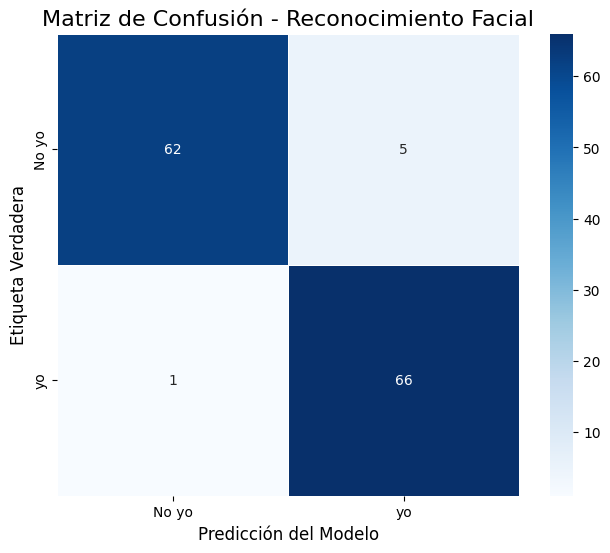

AUC-ROC: 0.9953218979728224
Imagen 0: Probabilidad de ser yo: 0.92, Label real: 1.0
Imagen 1: Probabilidad de ser yo: 0.84, Label real: 1.0
Imagen 2: Probabilidad de ser yo: 0.93, Label real: 1.0
Imagen 3: Probabilidad de ser yo: 0.91, Label real: 1.0
Imagen 4: Probabilidad de ser yo: 0.93, Label real: 1.0
Imagen 5: Probabilidad de ser yo: 0.95, Label real: 1.0
Imagen 6: Probabilidad de ser yo: 0.93, Label real: 1.0
Imagen 7: Probabilidad de ser yo: 0.92, Label real: 1.0
Imagen 8: Probabilidad de ser yo: 0.93, Label real: 1.0
Imagen 9: Probabilidad de ser yo: 0.88, Label real: 1.0


In [2]:
import pandas as pd
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


base_dir = r'C:\Users\LamdaZero\Desktop\Proyecto final REDES'
model_path = os.path.join(base_dir, 'face_recognizer_finetuned.h5')  
test_dir = os.path.join(base_dir, 'test_faces')  # Carpeta con subfolders positivas/negativas

model = load_model(model_path)

# Preparamos el dataframe de test 
positive_test_files = [os.path.join(test_dir, 'positive', f) for f in os.listdir(os.path.join(test_dir, 'positive')) if f.endswith(('.jpg', '.jpeg'))]
negative_test_files = [os.path.join(test_dir, 'negative', f) for f in os.listdir(os.path.join(test_dir, 'negative')) if f.endswith(('.jpg', '.jpeg'))]

test_df = pd.DataFrame({
    'path': positive_test_files + negative_test_files,
    'label': [1.0] * len(positive_test_files) + [0.0] * len(negative_test_files)
})

# Generador para test (sin augmentación)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    target_size=(96, 96),  
    batch_size=32,
    class_mode='raw',
    shuffle=False 
)

# Predecimos en test
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int).flatten() 
y_true = test_df['label'].values

# Métricas 
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=['No yo', 'Yo']))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
labels = ['No yo', 'yo']
plt.figure(figsize=(8, 6))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=labels, yticklabels=labels,
            cbar=True, square=True, linewidths=0.5)

plt.title('Matriz de Confusión - Reconocimiento Facial', fontsize=16)
plt.xlabel('Predicción del Modelo', fontsize=12)
plt.ylabel('Etiqueta Verdadera', fontsize=12)
plt.show()

# AUC-ROC
auc = roc_auc_score(y_true, predictions)
print("AUC-ROC:", auc)


# Para confianza por imagen (elegimos 10 ejemplos)
for i, pred in enumerate(predictions[:10]):  
    print(f"Imagen {i}: Probabilidad de ser yo: {pred[0]:.2f}, Label real: {y_true[i]}")

In [3]:
import os
from tensorflow.keras.models import load_model

base_dir = r'C:\Users\LamdaZero\Desktop\Proyecto final REDES'
model_path = os.path.join(base_dir, 'face_recognizer_finetuned.h5')


model = load_model(model_path)


score = model.evaluate(test_generator, verbose=1)
print("Loss en test:", score[0])
print("Accuracy en test:", score[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 493ms/step - accuracy: 0.9552 - loss: 0.1305
Loss en test: 0.1304597109556198
Accuracy en test: 0.9552238583564758
